In [1]:
import bayesfast as bf

In [2]:
from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)
client

/global/homes/n/nleslie/.conda/envs/cosmosis/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:43519 Dashboard: http://127.0.0.1:39903/status,Cluster Workers: 4 Cores: 4 Memory: 540.15 GB


In [3]:
import numpy as np

N = 10000 # number of samples to generate; the actual size may be smaller because of the prior
D = 16 # number of dims
a = 1.
b = 0.5

#funnel example
def logp(x):
    n = x.shape[-1]
    _a = -0.5 * x[..., 0]**2 / a**2
    _b = -0.5 * np.sum(x[..., 1:]**2, axis=-1) * np.exp(-2 * b * x[..., 0])
    _c = (-0.5 * np.log(2 * np.pi * a**2) - 
          0.5 * (n - 1) * np.log(2 * np.pi) - (n - 1) * b * x[..., 0])
    return _a + _b + _c

def grad(x):
    n = x.shape[-1]
    foo = -x / np.insert(np.full((*x.shape[:-1], n - 1), 
                                 np.exp(2 * b * x[..., 0])), 0, a**2, axis=-1)
    foo[0] += b * np.sum(x[..., 1:]**2, axis=-1) * np.exp(-2 * b * x[..., 0])
    foo[0] -= (n - 1) * b
    return foo

In [4]:
den = bf.DensityLite(logp=logp, grad=grad, input_size=D)

In [5]:
import numpy as np
from bayesfast.utils import random as bfrandom
D = 16
x_test = bfrandom.multivariate_normal(
                np.zeros(D), np.eye(D), 1, skip = 100)

def logbase(x):
    return -1/2*np.sum([y**2 for y in x])-D/2*np.log(2*np.pi)

def gradlogbase(x):
    return -x

base = bf.DensityLite(logp=logbase, grad=gradlogbase, input_size=D)

In [6]:
# from bayesfast.samplers import TTrace
# trace = TTrace(n_iter=6000, n_warmup=1000)
sam = bf.sample(den, base=base, client=client, sampler='THMC')

 CHAIN #2 : sampling proceeding [ 300 / 1500 ], last 300 samples used 3.10 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 300 samples used 3.18 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 300 samples used 3.13 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 300 samples used 3.26 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.58 seconds.
 CHAIN #2 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.75 seconds.
 CHAIN #3 : sampling proceeding [ 600 / 1500 ], last 300 samples used 3.07 seconds.
 CHAIN #1 : sampling proceeding [ 600 / 1500 ], last 300 samples used 3.51 seconds.
 CHAIN #0 : sampling proceeding [ 900 / 1500 ], last 300 samples used 2.59 seconds.
 CHAIN #2 : sampling proceeding [ 900 / 1500 ], last 300 samples used 2.68 seconds.
 CHAIN #3 : sampling proceeding [ 900 / 1500 ], last 300 samples used 3.07 seconds.
 CHAIN #1 : sampling proceeding [ 900 / 

In [8]:
# sam_nuts = bf.sample(den, client=client)

In [9]:
sam().shape

(4, 1000, 16)

Removed no burn in


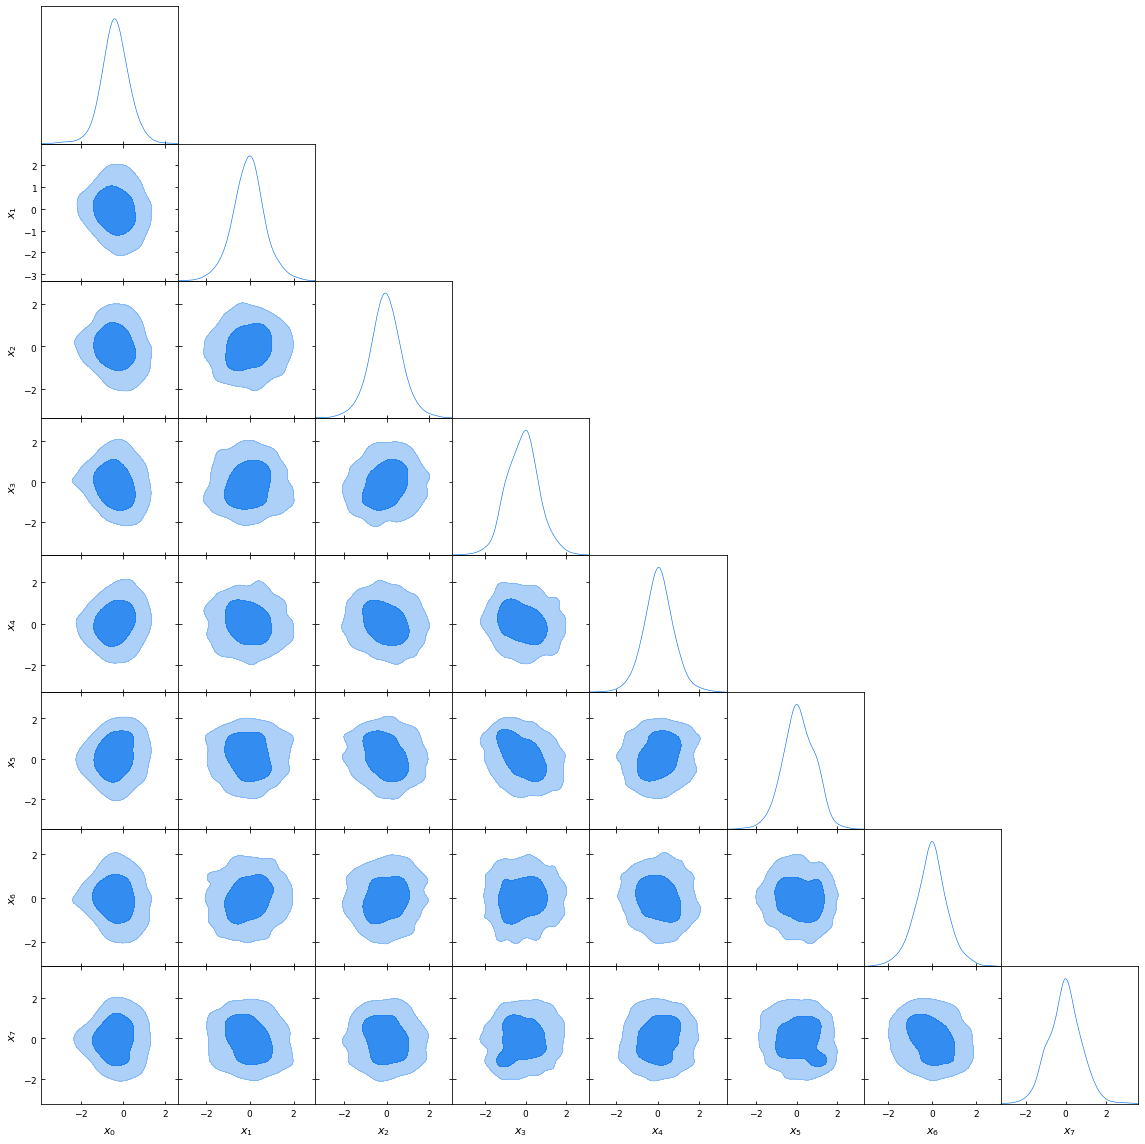

In [10]:
%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

n_show = 8
names = ["x_%s"%i for i in range(n_show)]
labels = ["x_%s"%i for i in range(n_show)]
s = MCSamples(samples=sam().reshape((-1, D))[:, :n_show], names=names, labels=labels)
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.triangle_plot([s], filled=True, contour_args={'alpha':0.8})
plt.show()

In [11]:
# 4-D Gaussian Mixture Target
# mu1 = np.array([-0.5, 0.2, -0.3, 0.4])
# sig1 = np.array([0.1, 0.1, 0.1, 0.1])
# mu2 = np.array([0.3, -0.4, 0.1, 0.1])
# sig2 = np.array([0.1, 0.1, 0.1, 0.1])
mu1 = np.array([-0.5, -0.5, -0.5, -0.5])
sig1 = np.array([0.1, 0.1, 0.1, 0.1])
mu2 = np.array([0.4, 0.4, 0.4, 0.4])
sig2 = np.array([0.1, 0.1, 0.1, 0.1])
D = 4

# # 2-D Gaussian Mixture Target
# mu1 = np.array([-0.5, -0.3])
# sig1 = np.array([0.1, 0.1])
# mu2 = np.array([0.3, 0.2])
# sig2 = np.array([0.1, 0.1])
# D = 2

def mvgaussian(x, mu, sigma):
    return np.exp(-1/2*np.sum(((x-mu)/sigma)**2))/np.sqrt(np.product(2*np.pi*sigma))

def d_mvgaussian(x, mu, sigma):
    return (mu-x)/sigma**2*mvgaussian(x, mu, sigma)

def gmp(x):
    return 1/2*( mvgaussian(x, mu1, sig1) + mvgaussian(x, mu2, sig2) )

def gmlogp(x):
    return np.log(gmp(x))

def gradgmlogp(x):
    return (d_mvgaussian(x, mu1, sig1) + d_mvgaussian(x, mu2, sig2))/(mvgaussian(x, mu1, sig1) + mvgaussian(x, mu2, sig2))

# Plot 2-D Gaussian
# def gmp2d(x,y):
#     X = np.array([x,y])
#     return gmp(X)

# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# from matplotlib import cm
# import numpy as np

# x = np.linspace(-1,1,50)
# y = np.linspace(-1,1,50)
# z = np.zeros((50,50))
# for i in range(50):
#     for j in range(50):
#         z[i][j] = gmp2d(x[i],y[j])

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.contour3D(x, y, z, 50, cmap=cm.coolwarm)
# ax.set_xlabel('$x_0$')
# ax.set_ylabel('$x_1$')
# ax.set_zlabel('p');
# ax.view_init(30,40)       

# plt.show()


array([39.99999863, 39.99999863, 39.99999863, 39.99999863])

In [12]:
gmden = bf.DensityLite(logp=gmlogp, grad=gradgmlogp, input_size=D)
gmbase = bf.DensityLite(logp=logbase, grad=gradlogbase, input_size=D)
gmsam = bf.sample(gmden, base=gmbase, client=client, sampler='THMC')

/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #3 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #3 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #1 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #1 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #0 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:157: RuntimeWarning:  CHAIN #0 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sam

 CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.50 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.64 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.73 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 300 samples used 1.84 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.53 seconds.
 CHAIN #2 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.44 seconds.
 CHAIN #3 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.34 seconds.
 CHAIN #1 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.08 seconds.
 CHAIN #3 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.20 seconds.
 CHAIN #0 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.52 seconds.
 CHAIN #2 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.44 seconds.
 CHAIN #1 : sampling proceeding [ 900 / 

In [13]:
gmsam().shape

(4, 1000, 4)

Removed no burn in


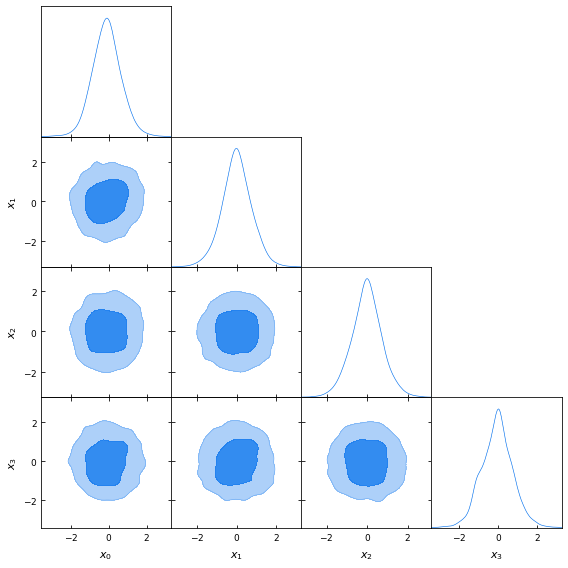

In [14]:
names = ["x_%s"%i for i in range(D)]
labels = ["x_%s"%i for i in range(D)]
s = MCSamples(samples=sam().reshape((-1, D)), names=names, labels=labels)
g = plots.getSubplotPlotter()
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.triangle_plot([s], filled=True, contour_args={'alpha':0.8})
plt.show()

In [ ]:
# 1-D Graham '17 example
import bayesfast as bf
import numpy as np
from bayesfast.samplers import TTrace, HTrace

from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

mu_1 = -8
mu_2 = 8
sigma_1 = 1
sigma_2 = 2
p_1 = 0.6
p_2 = 0.4
D=1

var_mean = p_1 * mu_1 + p_2 * mu_2
var_std = (
    p_1 * sigma_1**2 + p_2 * sigma_2**2 + 
    p_1 * mu_1**2 + p_2 * mu_2**2 - var_mean**2
)**0.5

def phi(x):
    return -np.log(
    (p_1 / (2 * np.pi * sigma_1**2)**0.5) * np.exp(-0.5 * ((x - mu_1) / sigma_1)**2) +
    (p_2 / (2 * np.pi * sigma_2**2)**0.5) * np.exp(-0.5 * ((x - mu_2) / sigma_2)**2)
    )

def psi(x):
    return 0.5 * ((x - var_mean) / var_std)**2 + 0.5 * np.log(2 * np.pi) + np.log(var_std)

def mphi(x):
    return np.log(
    (p_1 / (2 * np.pi * sigma_1**2)**0.5) * np.exp(-0.5 * ((x - mu_1) / sigma_1)**2) +
    (p_2 / (2 * np.pi * sigma_2**2)**0.5) * np.exp(-0.5 * ((x - mu_2) / sigma_2)**2)
    )

def gradmphi(x):
    num = (mu_1 - x) / (sigma_1**2) * (p_1 / (2 * np.pi * sigma_1**2)**0.5) * np.exp(-0.5 * ((x - mu_1) / sigma_1)**2) + (mu_2 - x) / (sigma_2**2) * (p_2 / (2 * np.pi * sigma_2**2)**0.5) * np.exp(-0.5 * ((x - mu_2) / sigma_2)**2)

    denom = (p_1 / (2 * np.pi * sigma_1**2)**0.5) * np.exp(-0.5 * ((x - mu_1) / sigma_1)**2) + (p_2 / (2 * np.pi * sigma_2**2)**0.5) * np.exp(-0.5 * ((x - mu_2) / sigma_2)**2)

    return num/denom
    
def mpsi(x):
    return -0.5 * ((x - var_mean) / var_std)**2 - 0.5 * np.log(2 * np.pi) - np.log(var_std)

def gradmpsi(x):
    return (var_mean-x)/var_std**2

testden = bf.DensityLite(logp=mphi, grad=gradmphi, input_size=D)
testbase = bf.DensityLite(logp=mpsi, grad=gradmpsi, input_size=D)
# testsam = bf.sample(testden, base=testbase, trace=trace, client=client, sampler='THMC', n_steps=20, dt=1)
testsam = bf.sample(testden, base=testbase, client=client, sampler='THMC')
hmctrace = HTrace(n_chain=4, n_iter=1000, n_warmup=100, adapt_step_size=False, step_size=1, adapt_metric=False)
testsam_hmc = bf.sample(testden, trace=hmctrace, client=client, sampler='HMC', n_steps=20, dt = 1)

%matplotlib inline
from getdist import plots, MCSamples
import matplotlib.pyplot as plt

# names = ["x_%s"%i for i in range(D)]
# labels = ["x_%s"%i for i in range(D)]
# s = MCSamples(samples=testsam().reshape((-1, D)), names=names, labels=labels)
# g = plots.getSubplotPlotter()
# g.settings.axes_fontsize = 12
# g.settings.lab_fontsize = 14
# g.triangle_plot([s], filled=True, contour_args={'alpha':0.8})

# fig = plt.figure(figsize=(6, 3))
# ax = fig.add_subplot(1, 1, 1)
# xs = np.linspace(-20, 20, 200)
# ax.plot(xs, np.exp(-phi(xs)))
# ax.plot(xs, np.exp(-psi(xs)))
# ax.legend([r'Target $\,\frac{1}{Z}\,\exp[-\phi(x)]$', r'Base $\,\exp[-\psi(x)]$'])
# ax.set_xlabel(r'Target state $x$')
# ax.set_ylabel(r'Probability density')
# ax.set_xticklabels(['{0:.0f}'.format(tick) for tick in ax.get_xticks()], fontsize=9)
# ax.set_yticklabels(['{0:.2f}'.format(tick) for tick in ax.get_yticks()], fontsize=9)
# fig.tight_layout(pad=0)
# plt.show()

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 3))
xs = np.linspace(-20, 20, 200)
axes[0].plot(xs, np.exp(-phi(xs)))
axes[1].plot(xs, np.exp(-phi(xs)))
axes[0].hist(testsam_hmc.samples.reshape(-1), 15, normed=True, alpha=0.8)
axes[1].hist(testsam.samples.reshape(-1), 50, weights=testsam.pbeta1.reshape(-1), normed=True, alpha=0.8)
axes[1].set_xlabel(r'Target state $x$')
axes[0].set_ylabel(r'Probability density')
axes[1].set_ylabel(r'Probability density')
axes[0].legend(['Target', 'HMC'], ncol=1, loc='upper left')
axes[1].legend(['Target', 'CT HMC'], ncol=1, loc='upper left')
fig.show()

/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #3 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #3 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #1 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #1 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #1 : invalid value encountered in add
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #2 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:1

 CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 300 samples used 2.11 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 300 samples used 2.17 seconds. (warmup)
 CHAIN #2 : sampling proceeding [ 300 / 1500 ], last 300 samples used 2.22 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 300 samples used 2.43 seconds. (warmup)


/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #0 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #0 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #0 : invalid value encountered in add
  warnings.warn(msg[1], msg[0])


 CHAIN #1 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.77 seconds.
 CHAIN #0 : sampling proceeding [ 600 / 1500 ], last 300 samples used 1.92 seconds.
 CHAIN #2 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.25 seconds.
 CHAIN #3 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.13 seconds.
 CHAIN #1 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.64 seconds.
 CHAIN #0 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.85 seconds.
 CHAIN #3 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.98 seconds.
 CHAIN #2 : sampling proceeding [ 900 / 1500 ], last 300 samples used 2.16 seconds.
 CHAIN #0 : sampling proceeding [ 1200 / 1500 ], last 300 samples used 1.84 seconds.
 CHAIN #1 : sampling proceeding [ 1200 / 1500 ], last 300 samples used 2.36 seconds.
 CHAIN #2 : sampling proceeding [ 1200 / 1500 ], last 300 samples used 1.91 seconds.
 CHAIN #3 : sampling proceeding [ 1200 / 1500 ], last 300 samples used 2.

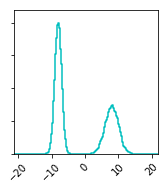

In [27]:
import corner
xs = testsam.samples.reshape(-1)
ws = testsam.pbeta1.reshape(-1)
fig = corner.corner(xs, bins=400, weights=ws, color='c', smooth1d=2)

In [1]:
import bayesfast as bf
import numpy as np
import corner
from bayesfast.samplers import TTrace, HTrace

from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)

# n-D Gaussian Mixture Target
d = 6
s = 1
bs = d
D = 4
mu1 = np.zeros(D)
mu1[0] = d
mu2 = np.zeros(D)
mu2[0] = -d
sig1 = np.full(D, s)
sig2 = np.full(D, s)

# Gaussians
def mvgaussian(x, mu, sigma):
    return np.exp(-1/2*np.sum(((x-mu)/sigma)**2))/np.sqrt(np.product(2*np.pi*sigma))

def d_mvgaussian(x, mu, sigma):
    return (mu-x)/sigma**2*mvgaussian(x, mu, sigma)

def loggaussian(x, mu, sigma):
    return -1/2*np.sum(((x-mu)/sigma)**2) - 1/2*np.sum(np.log(2*np.pi*sigma))

def d_loggaussian(x, mu, sigma):
    return (mu-x)/sigma**2

# Base and target
def logbase(x):
    return loggaussian(x, np.zeros(D), np.full(D, bs))

def gradlogbase(x):
    return -x/bs**2

def testlogp(x):
    return np.log(mvgaussian(x, mu1, sig1) + mvgaussian(x, mu2, sig2))

def testgrad(x):
    num = d_mvgaussian(x, mu1, sig1) + d_mvgaussian(x, mu2, sig2)
    denom = mvgaussian(x, mu1, sig1) + mvgaussian(x, mu2, sig2)
    return num/denom

testden = bf.DensityLite(logp=testlogp, grad=testgrad, input_size=D)
# unit gaussian
testbase = bf.DensityLite(logp=logbase, grad=gradlogbase, input_size=D)
# trace = TTrace(n_iter=5000, n_warmup=100)
# testsam = bf.sample(testden, base=testbase, trace=trace, client=client, sampler='THMC')
testsam = bf.sample(testden, base=testbase, client=client, sampler='THMC')

# %matplotlib inline
# from getdist import plots, MCSamples
# import matplotlib.pyplot as plt

# names = ["x_%s"%i for i in range(D)]
# labels = ["x_%s"%i for i in range(D)]
# s = MCSamples(samples=testsam().reshape((-1, D)), names=names, labels=labels)
# g = plots.getSubplotPlotter()
# g.settings.axes_fontsize = 12
# g.settings.lab_fontsize = 14
# g.triangle_plot([s], filled=True, contour_args={'alpha':0.8})
# plt.show()

xs = testsam.samples.reshape((-1, D))
ws = testsam.pbeta1.reshape(-1)
fig = corner.corner(xs, bins=50, weights=ws, color='c')
fig.show()

/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #2 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #2 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #2 : invalid value encountered in double_scalars
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #0 : divide by zero encountered in log
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #0 : invalid value encountered in true_divide
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayesfast/core/sample.py:169: RuntimeWarning:  CHAIN #0 : invalid value encountered in double_scalars
  warnings.warn(msg[1], msg[0])
/global/u1/n/nleslie/bayesfast/bayes

 CHAIN #2 : sampling proceeding [ 300 / 1500 ], last 300 samples used 2.93 seconds. (warmup)
 CHAIN #1 : sampling proceeding [ 300 / 1500 ], last 300 samples used 2.92 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 300 / 1500 ], last 300 samples used 2.94 seconds. (warmup)
 CHAIN #3 : sampling proceeding [ 300 / 1500 ], last 300 samples used 3.09 seconds. (warmup)
 CHAIN #0 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.05 seconds.
 CHAIN #2 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.74 seconds.
 CHAIN #1 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.90 seconds.
 CHAIN #3 : sampling proceeding [ 600 / 1500 ], last 300 samples used 2.79 seconds.
 CHAIN #0 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.90 seconds.
 CHAIN #3 : sampling proceeding [ 900 / 1500 ], last 300 samples used 1.88 seconds.
 CHAIN #2 : sampling proceeding [ 900 / 1500 ], last 300 samples used 2.50 seconds.
 CHAIN #0 : sampling proceeding [ 1200 /

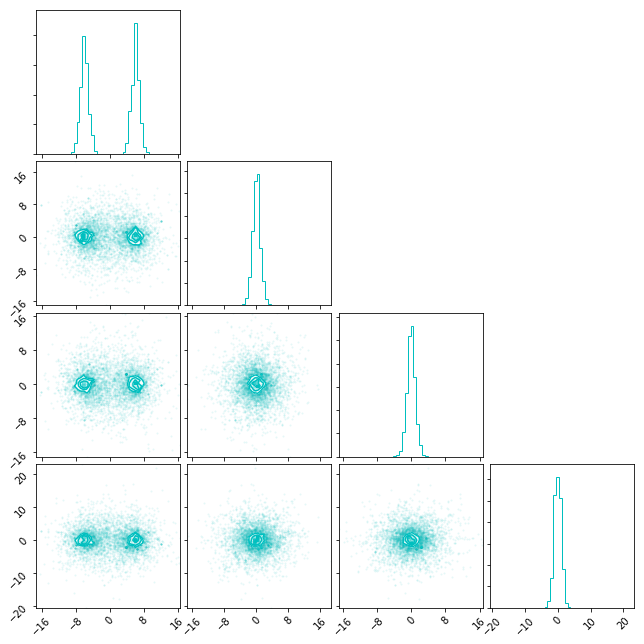

In [2]:
xs.shape
xs = testsam.samples.reshape((-1, D))
ws = testsam.pbeta1.reshape(-1)
fig = corner.corner(xs, bins=50, weights=ws, color='c')

(10000, 2)


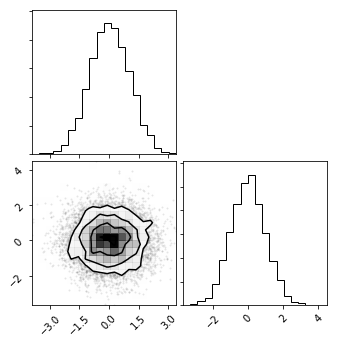

In [15]:
import corner
import numpy as np

ndim, nsamples = 2, 10000
np.random.seed(42)
samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])
weights = np.exp(np.random.randn(nsamples))
figure = corner.corner(samples, weights=weights)
print(samples.shape)

In [ ]:
# Eggbox example
import bayesfast as bf
import numpy as np
import corner
from bayesfast.samplers import TTrace, NTrace

from distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)


# Functions
def logeggbox(x):
    return (2.0+np.sin(5*np.pi*(x[0]-1.0))*np.sin(5*np.pi*(x[1]-1.0)))**5 - 200*((x[0]-0.5)**4+(x[1]-0.5)**4)

def gradlogeggbox(x):
    dx = 5*(2.0+np.sin(5*np.pi*(x[0]-1.0))*np.sin(5*np.pi*(x[1]-1.0)))**4*5*np.pi*np.cos(5*np.pi*(x[0]-1.0))*np.sin(5*np.pi*(x[1]-1.0))
    - 800*(x[0]-0.5)**3
    dy = 5*(2.0+np.sin(5*np.pi*(x[0]-1.0))*np.sin(5*np.pi*(x[1]-1.0)))**4*5*np.pi*np.sin(5*np.pi*(x[0]-1.0))*np.cos(5*np.pi*(x[1]-1.0))
    - 800*(x[1]-0.5)**3
    return np.array([dx, dy])

def logbase(x):
    return -200*((x[0]-0.5)**4+(x[1]-0.5)**4)

def gradlogbase(x):
    return np.array([-800*(x[0]-0.5)**3, -800*(x[1]-0.5)**3])


den = bf.DensityLite(logp=logeggbox, grad=gradlogeggbox, input_size=2)
base = bf.DensityLite(logp=logbase, grad=gradlogbase, input_size=2)

trace = TTrace(n_iter=60000, n_warmup=1000, x_0=[[0.5,0.5]], step_size=0.2, adapt_step_size=False, use_nuts=False)
sam = bf.sample(den, base=base, trace=trace, client=client, sampler='THMC', n_steps=5)
# sam = bf.sample(den, base=base, client=client, sampler='THMC')

# trace = NTrace(x_0=[[0.5,0.5]], max_treedepth=3)
# sam = bf.sample(den, trace=trace, client=client, sampler='NUTS')

print('Samples collected successfully.')

xs = sam.samples.reshape((-1, 2))
ws = sam.pbeta1.reshape(-1)
fig = corner.corner(xs, bins=50, weights=ws, color='c')
fig.show()


## 